This Jupyter notebook offers a practical demonstration of how to utilize the `PreFab` library for correcting the fabrication of a target structure using a Silicon-On-Insulator (SOI) e-beam process. The tutorial is designed to help you navigate the following steps:

1. Preparing an image of the fleur-de-lis structure for correction
2. Executing the correction process
3. Analyzing the results of the correction

To begin, let's import the necessary libraries:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import prefab as pf

Initially, we prepare a device image for correction. This involves loading an image of a device as a numpy matrix. Pixel values should be binary: 0 or 1. For this tutorial, we use an image of a target, but feel free to try other devices in the devices/ directory, or even add your own images.

Please remember that the image scale should be 1 nm/px. If it's not, ensure you specify the actual length of the device image (in nm) when loading the image.


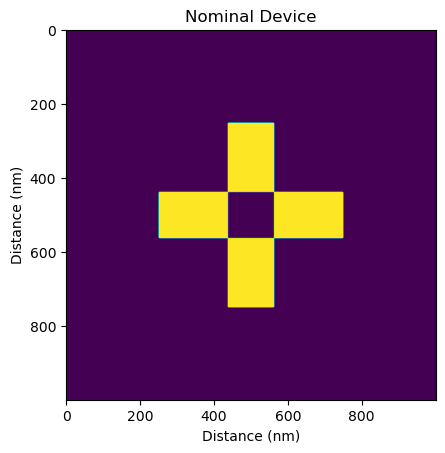

In [2]:
IMG_LENGTH_NM = 1000
device = pf.load_device_img(
    path="../devices/target_32x128_256x256.png", img_length_nm=IMG_LENGTH_NM
)

plt.imshow(device)
plt.title("Nominal Device")
plt.ylabel("Distance (nm)")
plt.xlabel("Distance (nm)")
plt.show()

Next, we perform the correction on our target structure. Each model is distinctively identified by the name of the fabrication facility and process, the model version, and the dataset version used for training. Please refer to [docs/models.md](docs/models.md) for a list of available models.

At this point, we will opt for a binarized output. By default, the corrector provides raw corrections, which include "fuzzy" or uncertain areas of the structure that may vary between different fabrication runs or even between different instances of the same target structure on the same chip. However, choosing a binarized output, the corrector will output the most likely corrected design, creating a fabricatable structure. It's also possible to binarize the output post-correction, allowing you to compare both the raw and binarized corrections.


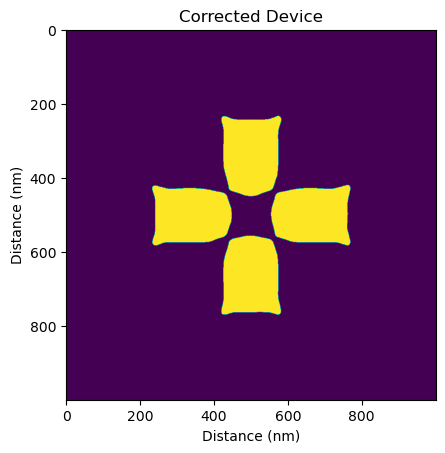

In [3]:
# Performance note: The first correction might take longer as the cloud server starts and loads the necessary model(s). Subsequent predictions should be quicker.
MODEL_NAME = "ANT_NanoSOI"
MODEL_TAGS = "v6-d7"
correction = pf.correct(
    device=device, model_name=MODEL_NAME, model_tags=MODEL_TAGS, binarize=True
)

plt.imshow(pf.binarize(correction))
plt.title("Corrected Device")
plt.ylabel("Distance (nm)")
plt.xlabel("Distance (nm)")
plt.show()

Our next step is to visualize the difference between the nominal and corrected designs for the target structure. The corrector compensates for expected fabrication errors by adjusting the design. It adds silicon in places where it predicts an over-etch and removes silicon where it predicts an under-etch.


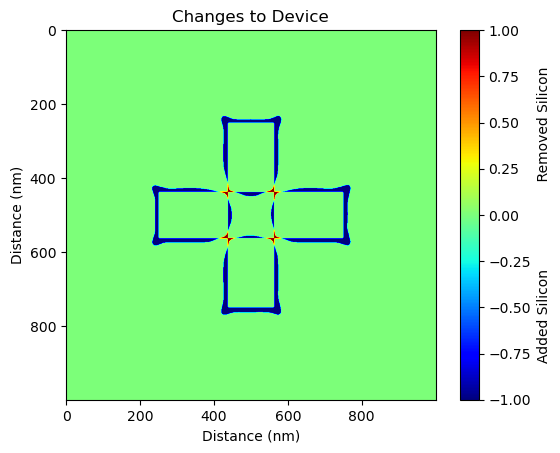

In [4]:
variation = device - correction
plt.imshow(variation, cmap="jet", vmin=-1, vmax=1)
plt.title("Changes to Device")
plt.ylabel("Distance (nm)")
plt.xlabel("Distance (nm)")
cb = plt.colorbar()
cb.set_label("Added Silicon                    Removed Silicon")
plt.show()

In the next step, we predict the fabrication outcomes for both the nominal and corrected target structures using the prediction model. We then visualize the predicted outcomes, highlighting the fidelity improvements achieved through the correction process.

In the corrected design, the corners are expected to be sharper and the middle openings are better resolved compared to the nominal design. Additionally, the Intersection over Union (IoU) score, a common metric for comparing the similarity of two designs, is improved. This means that the corrected design will more closely match the intended design, leading to better fabrication outcomes.


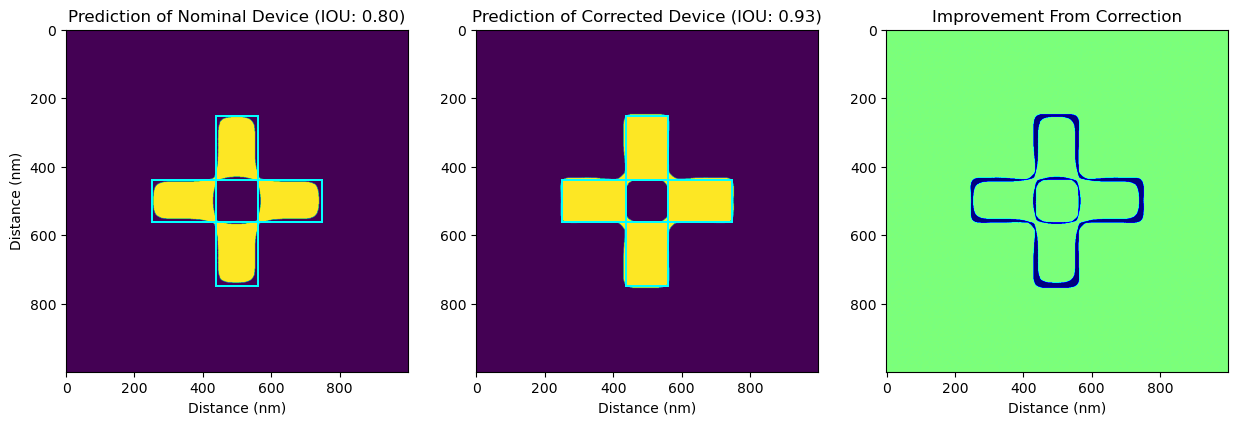

In [9]:
outcome = pf.predict(
    device=correction, model_name=MODEL_NAME, model_tags=MODEL_TAGS, binarize=True
)
prediction = pf.predict(
    device=device, model_name=MODEL_NAME, model_tags=MODEL_TAGS, binarize=True
)

def calculate_iou(prediction, device):
    intersection = np.logical_and(prediction, device)
    union = np.logical_or(prediction, device)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

iou_nominal = calculate_iou(prediction, device)
iou_corrected = calculate_iou(outcome, device)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(prediction)
axs[0].imshow(pf.generate_device_contour(device), cmap="cool")
axs[0].set_title(f"Prediction of Nominal Device (IOU: {iou_nominal:.2f})")
axs[0].set_ylabel("Distance (nm)")
axs[0].set_xlabel("Distance (nm)")
axs[1].imshow(outcome)
axs[1].imshow(pf.generate_device_contour(device), cmap="cool")
axs[1].set_title(f"Prediction of Corrected Device (IOU: {iou_corrected:.2f})")
axs[1].set_xlabel("Distance (nm)")
axs[2].imshow(prediction - outcome, cmap="jet", vmin=-1, vmax=1)
axs[2].set_title("Improvement From Correction")
axs[2].set_xlabel("Distance (nm)")
plt.show()

This concludes our tutorial! You are now ready to leverage the corrected model of your device to run simulations and anticipate its post-fabrication performance. This expertise enables you to improve the accuracy and repeatability of your nanostructures. We wish you the best in your future fabrication endeavors!
